### 📦 Libraries
- **numpy, pandas**: Data manipulation
- **yfinance**: Download stock prices
- **arch**: GARCH modeling
- **matplotlib**: Plotting results


In [105]:
import numpy as np
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

### 💹 Data Download & Preprocessing
- Download daily adjusted closing prices for 5 assets
- Use last 2 years (~501 trading days)
- Compute **daily log returns**
- Define **equal portfolio weights**


In [106]:
# List of tickers
tickers = ['AAPL', 'JNJ', 'XOM', 'JPM', 'WMT']

# Download daily adjusted closing prices
data = yf.download(tickers, start='2023-01-01', end='2025-01-02', interval='1d', auto_adjust=True)['Close']
data = data.dropna()

# Keep last 2 years (~501 trading days)
closing_prices = data[-501:]

# Compute daily log returns
log_returns = np.log(closing_prices / closing_prices.shift(1)).dropna()

# Portfolio weights
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

[*********************100%***********************]  5 of 5 completed


### ⚙️ Parameters for Monte Carlo GARCH-t VaR
- **window**: rolling estimation period (~1 year)
- **simulations**: number of Monte Carlo simulations
- **alpha_95 / alpha_99**: confidence levels for VaR
- **out_of_sample**: number of days to test VaR


In [107]:
window = 250              # Rolling window ~1 year
simulations = 10000       # Monte Carlo simulations
alpha_95 = 0.05           # 95% VaR
alpha_99 = 0.01           # 99% VaR
N = len(tickers)
out_of_sample = len(log_returns) - window

### 🎲 Multivariate t Simulation Function
- Simulates **n portfolio return scenarios** using:
  - Mean vector
  - Covariance matrix
  - Degrees of freedom (t-distribution)

In [108]:
def multivariate_t_rvs(mean, cov, df, n):
    """Simulate n samples from a multivariate Student-t distribution."""
    d = len(mean)
    g = np.tile(np.random.gamma(df/2., 2./df, n), (d,1)).T
    Z = np.random.multivariate_normal(np.zeros(d), cov, n)
    return mean + Z / np.sqrt(g)

### 📊 Rolling Monte Carlo GARCH-t VaR
For each day in the out-of-sample period:
1. Fit **GARCH-t model** to each asset to forecast volatility
2. Compute **correlation matrix** over the past window
3. Build **covariance matrix** Σ = D * R * D
4. Simulate **portfolio returns** with multivariate t
5. Compute **95% and 99% VaR**


In [109]:
mc_var_95 = []
mc_var_99 = []

for t in range(window, window + out_of_sample):
    
    # Correlation matrix over past window
    R = log_returns.iloc[t-window:t].corr().values
    
    sigma_forecasts = []
    dfs_t = []

    # Fit GARCH-t for each asset
    for i in range(N):
        series = log_returns.iloc[t-window:t, i] * 100  # rescale for arch
        model = arch_model(series, vol='GARCH', p=1, q=1, dist='t', rescale=False)
        fit = model.fit(disp='off')
        sigma_forecasts.append(np.sqrt(fit.forecast(horizon=1).variance.values[-1, 0]) / 100)
        dfs_t.append(max(fit.params["nu"], 2.1))  # ensure df>2

    sigma_forecasts = np.array(sigma_forecasts)
    avg_df = np.mean(dfs_t)

    # Covariance matrix Σ = D * R * D (already positive definite)
    D = np.diag(sigma_forecasts)
    cov_matrix = D @ R @ D

    # Monte Carlo simulation
    sim_returns = multivariate_t_rvs(mean=np.zeros(N), cov=cov_matrix, df=avg_df, n=simulations)
    port_returns = sim_returns @ weights

    # Compute VaR
    mc_var_95.append(np.percentile(port_returns, 100*alpha_95))
    mc_var_99.append(np.percentile(port_returns, 100*alpha_99))

### 📝 Prepare Data for Analysis
- Convert Monte Carlo VaR lists to **Pandas Series**
- Align with realized portfolio returns for plotting & testing


In [110]:
mc_var_95 = pd.Series(mc_var_95, index=log_returns.index[window:])
mc_var_99 = pd.Series(mc_var_99, index=log_returns.index[window:])

realized_returns = log_returns @ weights
realized_returns = realized_returns[window:]

### 📈 Plot Portfolio Returns vs VaR
- Plot **realized returns** and **VaR lines** (95%, 99%)
- Highlight **breaches** where losses exceed VaR
- Use **Seaborn** for a clean, student-friendly visualization


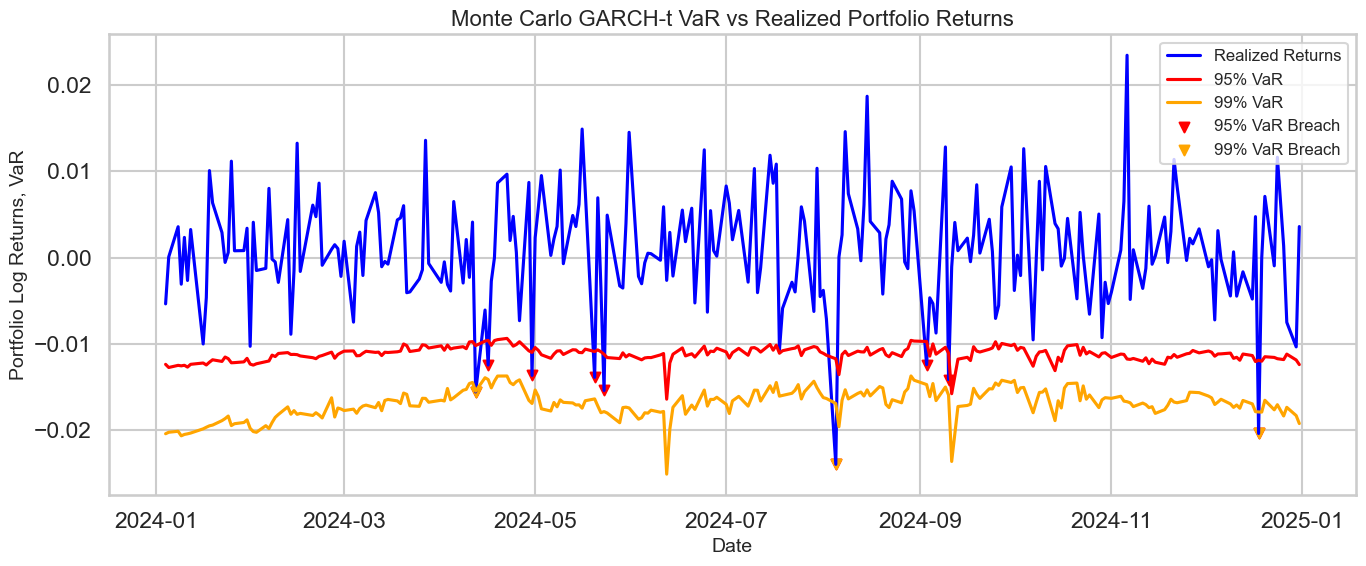

In [134]:
import seaborn as sns

# Set Seaborn style
sns.set(style='whitegrid', palette='muted', context='talk')

plt.figure(figsize=(14,6))

# Plot realized returns
sns.lineplot(x=realized_returns.index, y=realized_returns, label='Realized Returns', color='blue')

# Plot VaR lines
sns.lineplot(x=mc_var_95.index, y=mc_var_95, label='95% VaR', color='red')
sns.lineplot(x=mc_var_99.index, y=mc_var_99, label='99% VaR', color='orange')

# Highlight breaches
breaches_95 = realized_returns < mc_var_95
breaches_99 = realized_returns < mc_var_99
plt.scatter(realized_returns.index[breaches_95], realized_returns[breaches_95],
            color='red', marker='v', s=50, label='95% VaR Breach')
plt.scatter(realized_returns.index[breaches_99], realized_returns[breaches_99],
            color='orange', marker='v', s=50, label='99% VaR Breach')

# Labels and title
plt.title('Monte Carlo GARCH-t VaR vs Realized Portfolio Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Log Returns, VaR', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### ✅ Kupiec Proportion of Failures (POF) Test
- Checks if the **number of VaR breaches** matches the expected frequency
- **High p-value (>0.05)** → VaR is consistent with realized returns


In [112]:
import numpy as np
from scipy.stats import chi2

def kupiec_test(realized, var, alpha):
    """
    Kupiec Proportion of Failures (POF) test for VaR backtesting.

    realized : Series of realized portfolio returns
    var      : Series of VaR estimates
    alpha    : confidence level (e.g., 0.05 for 95% VaR)
    """
    # Count breaches
    breaches = (realized < var).sum()
    n = len(realized)
    expected = n * alpha

    # Likelihood ratio
    p_hat = breaches / n
    LR = -2 * np.log(
        ((1-alpha)**(n-breaches) * alpha**breaches) /
        ((1-p_hat)**(n-breaches) * p_hat**breaches)
    )
    
    p_value = 1 - chi2.cdf(LR, df=1)

    print(f"Kupiec Test (alpha={alpha*100:.0f}%):")
    print(f"LR = {LR:.2f}, p-value = {p_value:.4f}, breaches = {breaches}, expected = {expected:.1f}\n")

# Run Kupiec test
kupiec_test(realized_returns, mc_var_95, alpha=0.05)
kupiec_test(realized_returns, mc_var_99, alpha=0.01)

Kupiec Test (alpha=5%):
LR = 1.14, p-value = 0.2860, breaches = 9, expected = 12.5

Kupiec Test (alpha=1%):
LR = 0.09, p-value = 0.7580, breaches = 3, expected = 2.5



### 🔍 Christoffersen Independence Test
- Checks if VaR breaches **occur independently** (no clustering)
- **High p-value (>0.05)** → breaches appear random 


In [113]:
def christoffersen_test(realized, var):
    """
    Christoffersen test for VaR independence (no clustering of breaches).

    realized : Series of realized portfolio returns
    var      : Series of VaR estimates
    """
    # Breach indicator: 1 if breach, 0 otherwise
    breaches = (realized < var).astype(int)
    
    n00 = n01 = n10 = n11 = 0
    
    # Count transitions using positional indexing
    for i in range(1, len(breaches)):
        if breaches.iloc[i-1] == 0 and breaches.iloc[i] == 0:
            n00 += 1
        elif breaches.iloc[i-1] == 0 and breaches.iloc[i] == 1:
            n01 += 1
        elif breaches.iloc[i-1] == 1 and breaches.iloc[i] == 0:
            n10 += 1
        elif breaches.iloc[i-1] == 1 and breaches.iloc[i] == 1:
            n11 += 1

    # Transition probabilities
    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    # Likelihood ratio
    L0 = ((1-pi)**(n00+n10)) * (pi**(n01+n11))
    L1 = ((1-pi0)**n00) * (pi0**n01) * ((1-pi1)**n10) * (pi1**n11)
    LR = -2 * np.log(L0 / L1) if L1 > 0 else np.nan
    p_value = 1 - chi2.cdf(LR, df=1) if not np.isnan(LR) else np.nan

    print("Christoffersen Test:")
    print(f"LR = {LR:.2f}, p-value = {p_value:.4f}\n")

# Run Christoffersen test
christoffersen_test(realized_returns, mc_var_95)
christoffersen_test(realized_returns, mc_var_99)

Christoffersen Test:
LR = 0.68, p-value = 0.4113

Christoffersen Test:
LR = 0.07, p-value = 0.7868



### 📊 Parametric (Normal) VaR Baseline
- Assumes portfolio returns are normally distributed
- Uses rolling standard deviation over a 1-year window
- Computes 95% and 99% VaR


In [114]:
# Compute rolling portfolio std deviation
rolling_std = (log_returns @ weights).rolling(window).std()

# Parametric Normal VaR
param_var_95 = -1.65 * rolling_std[window:]  # 95% confidence, z-score
param_var_99 = -2.33 * rolling_std[window:]  # 99% confidence, z-score

# Align realized returns for comparison
realized_returns_baseline = (log_returns @ weights)[window:]

### 📈 EWMA VaR Baseline
- Exponentially Weighted Moving Average (RiskMetrics approach)
- Gives more weight to recent returns
- Captures volatility clustering in a simple way


In [115]:
lambda_ = 0.94  # decay factor
ewma_var_95 = []
ewma_var_99 = []

# Get realized portfolio returns
port_returns = log_returns @ weights

# Loop over out-of-sample period
for t in range(window, len(port_returns)):
    returns_window = port_returns[t-window:t]
    
    # EWMA variance
    sigma2 = 0
    for i in range(window):
        sigma2 += (lambda_**i) * returns_window.iloc[-(i+1)]**2
    sigma2 *= (1 - lambda_)
    
    sigma = np.sqrt(sigma2)
    
    # EWMA VaR (Parametric Normal)
    ewma_var_95.append(-1.65 * sigma)  # 95% VaR
    ewma_var_99.append(-2.33 * sigma)  # 99% VaR

# Convert to Series and align with realized returns
ewma_var_95 = pd.Series(ewma_var_95, index=port_returns.index[window:])
ewma_var_99 = pd.Series(ewma_var_99, index=port_returns.index[window:])

### 📊 Comparison of MC-GARCH-t, Parametric, and EWMA VaR
- Plot of realized returns and VaR from three models
- Along with breaches for visual comparison


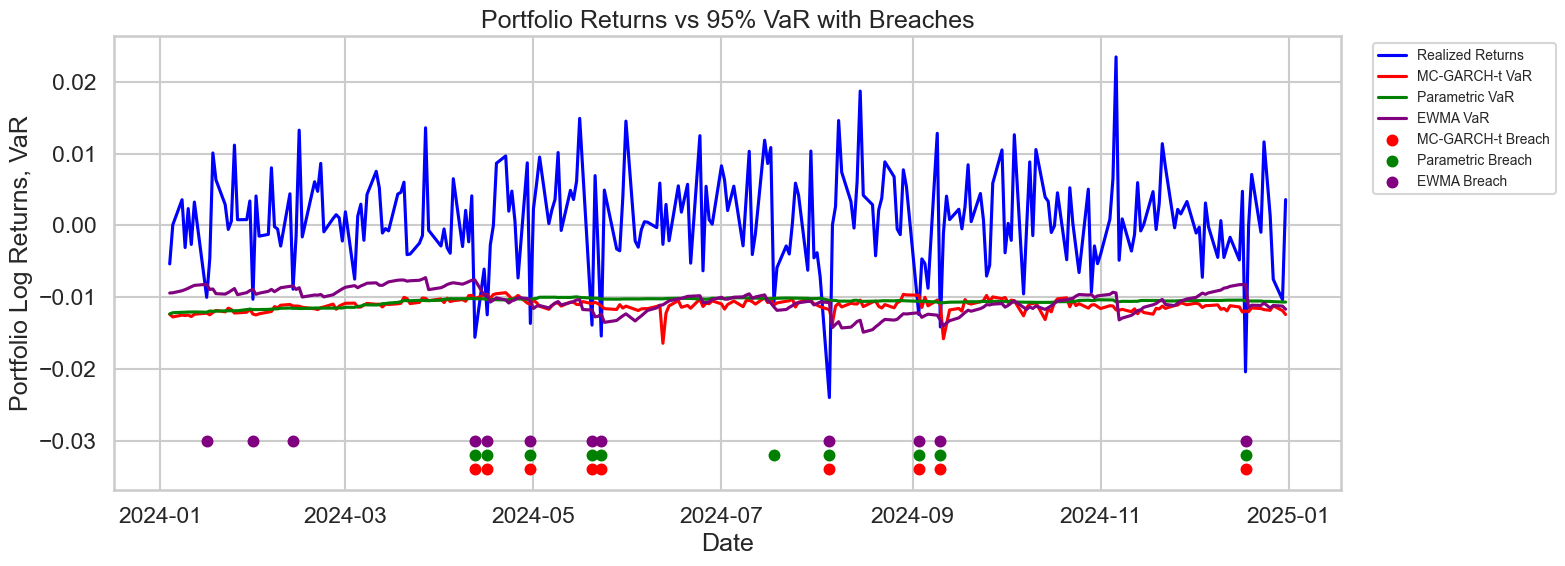

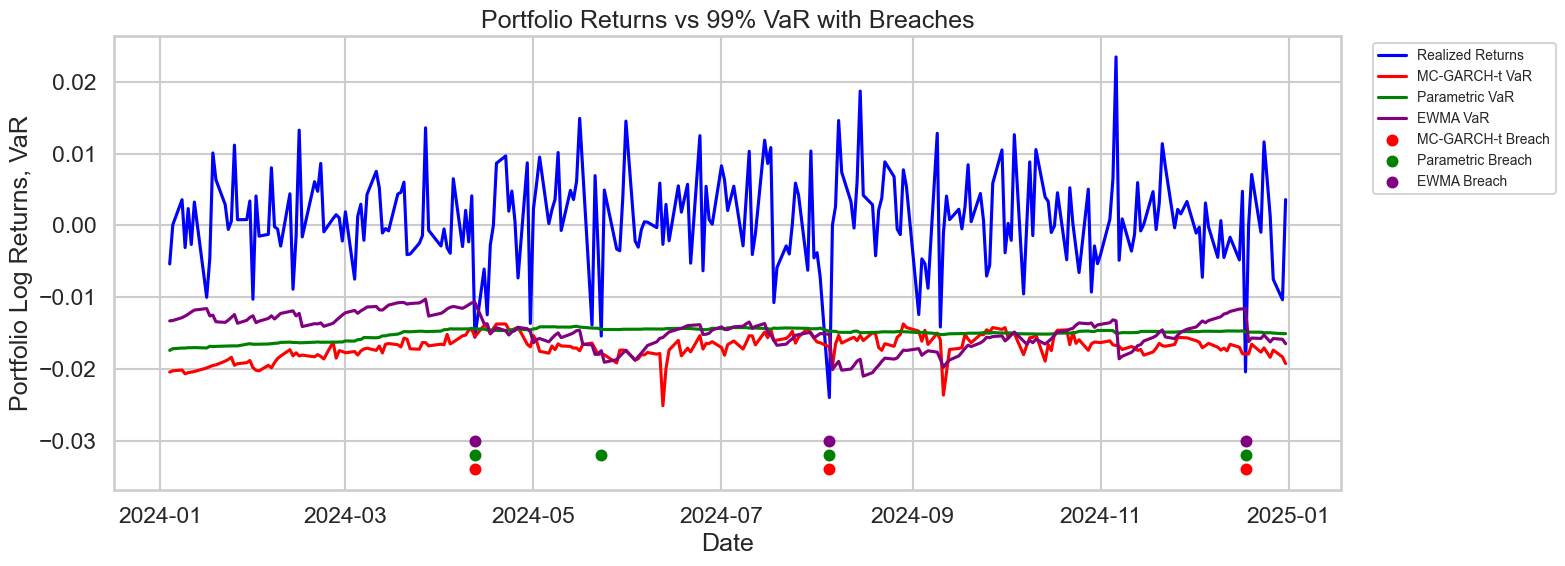

In [132]:
# --- Plot returns vs VaR with breach markers (student style)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='muted', context='talk')

# put breaches near bottom of chart
y_bottom = realized_returns.min() - 0.01
dot_size = 50
stack_offset = 0.002  # how much to stack dots vertically

def plot_var_with_breaches(realized, var_models, title):
    """
    Plot portfolio returns with VaR lines and mark breaches with dots.
    
    realized   : Series of realized portfolio returns
    var_models : dict with {'model_name': VaR_series}
    title      : string for chart title
    """
    plt.figure(figsize=(16,6))
    
    # plot portfolio returns
    sns.lineplot(x=realized.index, y=realized, label='Realized Returns', color='blue')
    
    # colors for each model
    colors = {'MC-GARCH-t':'red', 'Parametric':'green', 'EWMA':'purple'}
    
    # plot VaR lines
    for model_name, var in var_models.items():
        sns.lineplot(x=var.index, y=var, label=f'{model_name} VaR', color=colors[model_name])
    
    # add breach dots stacked if needed
    for i, (model_name, var) in enumerate(var_models.items()):
        breaches = realized < var
        y_pos = [y_bottom + i*stack_offset] * breaches.sum()
        plt.scatter(realized.index[breaches], y_pos, color=colors[model_name],
                    s=dot_size, marker='o', label=f'{model_name} Breach')
    
    # labels and title
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Log Returns, VaR')
    plt.legend(fontsize=10, bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()


# --- 95% VaR chart
plot_var_with_breaches(realized_returns, 
                       {'MC-GARCH-t': mc_var_95, 'Parametric': param_var_95, 'EWMA': ewma_var_95},
                       'Portfolio Returns vs 95% VaR with Breaches')

# --- 99% VaR chart
plot_var_with_breaches(realized_returns, 
                       {'MC-GARCH-t': mc_var_99, 'Parametric': param_var_99, 'EWMA': ewma_var_99},
                       'Portfolio Returns vs 99% VaR with Breaches')


### 1️⃣ Count breaches for all models
- Compute number of times realized portfolio returns exceed VaR
- This is a simple metric for basic comparison


In [117]:
# Number of breaches for each model
breaches_95 = {
    'MC-GARCH-t': (realized_returns < mc_var_95).sum(),
    'Parametric': (realized_returns_baseline < param_var_95).sum(),
    'EWMA': (realized_returns_baseline < ewma_var_95).sum()
}

breaches_99 = {
    'MC-GARCH-t': (realized_returns < mc_var_99).sum(),
    'Parametric': (realized_returns_baseline < param_var_99).sum(),
    'EWMA': (realized_returns_baseline < ewma_var_99).sum()
}

breaches_95, breaches_99


({'MC-GARCH-t': np.int64(9), 'Parametric': np.int64(10), 'EWMA': np.int64(12)},
 {'MC-GARCH-t': np.int64(3), 'Parametric': np.int64(4), 'EWMA': np.int64(3)})

### 2️⃣ Compute Kupiec and Christoffersen p-values
- Use the already defined functions from MC-GARCH-t cell
- Return p-values for all models and both VaR levels


In [118]:
def kupiec_result(realized, var, alpha):
    """
    Return Kupiec p-value and number of breaches for table.
    """
    breaches = (realized < var).sum()
    n = len(realized)
    expected = n * alpha
    p_hat = breaches / n
    LR = -2 * np.log(
        ((1-alpha)**(n-breaches) * alpha**breaches) /
        ((1-p_hat)**(n-breaches) * p_hat**breaches)
    )
    p_value = 1 - chi2.cdf(LR, df=1)
    return breaches, p_value


In [119]:
def christoffersen_result(realized, var):
    """
    Return Christoffersen p-value for table.
    """
    breaches = (realized < var).astype(int)
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(breaches)):
        if breaches.iloc[i-1]==0 and breaches.iloc[i]==0: n00+=1
        elif breaches.iloc[i-1]==0 and breaches.iloc[i]==1: n01+=1
        elif breaches.iloc[i-1]==1 and breaches.iloc[i]==0: n10+=1
        elif breaches.iloc[i-1]==1 and breaches.iloc[i]==1: n11+=1
    pi0 = n01/(n00+n01) if (n00+n01)>0 else 0
    pi1 = n11/(n10+n11) if (n10+n11)>0 else 0
    pi = (n01+n11)/(n00+n01+n10+n11) if (n00+n01+n10+n11)>0 else 0
    L0 = ((1-pi)**(n00+n10))*(pi**(n01+n11))
    L1 = ((1-pi0)**n00)*(pi0**n01)*((1-pi1)**n10)*(pi1**n11)
    LR = -2*np.log(L0/L1) if L1>0 else np.nan
    p_value = 1 - chi2.cdf(LR, df=1) if not np.isnan(LR) else np.nan
    return p_value


In [120]:

# Kupiec p-values
kupiec_95 = {
    'MC-GARCH-t': kupiec_result(realized_returns, mc_var_95, 0.05),
    'Parametric': kupiec_result(realized_returns_baseline, param_var_95, 0.05),
    'EWMA': kupiec_result(realized_returns_baseline, ewma_var_95, 0.05)
}

kupiec_99 = {
    'MC-GARCH-t': kupiec_result(realized_returns, mc_var_99, 0.01),
    'Parametric': kupiec_result(realized_returns_baseline, param_var_99, 0.01),
    'EWMA': kupiec_result(realized_returns_baseline, ewma_var_99, 0.01)
}

# Christoffersen p-values
christ_95 = {
    'MC-GARCH-t': christoffersen_result(realized_returns, mc_var_95),
    'Parametric': christoffersen_result(realized_returns_baseline, param_var_95),
    'EWMA': christoffersen_result(realized_returns_baseline, ewma_var_95)
}

christ_99 = {
    'MC-GARCH-t': christoffersen_result(realized_returns, mc_var_99),
    'Parametric': christoffersen_result(realized_returns_baseline, param_var_99),
    'EWMA': christoffersen_result(realized_returns_baseline, ewma_var_99)
}


### 3️⃣ Comparison table
- Breaches, Kupiec, and Christoffersen p-values, both 95% and 99% VaR

In [121]:
# Build DataFrames for 95% VaR
df_95 = pd.DataFrame({
    'Number of Breaches': [kupiec_95[m][0] for m in kupiec_95],
    'Kupiec p-value': [round(kupiec_95[m][1], 4) for m in kupiec_95],
    'Christoffersen p-value': [round(christ_95[m], 4) for m in christ_95]
}, index=kupiec_95.keys())

# Build DataFrames for 99% VaR
df_99 = pd.DataFrame({
    'Number of Breaches': [kupiec_99[m][0] for m in kupiec_99],
    'Kupiec p-value': [round(kupiec_99[m][1], 4) for m in kupiec_99],
    'Christoffersen p-value': [round(christ_99[m], 4) for m in christ_99]
}, index=kupiec_99.keys())

# Combine into MultiIndex table
comparison_all = pd.concat({'95% VaR': df_95, '99% VaR': df_99})
comparison_all


Number of Breaches  Kupiec p-value  Christoffersen p-value
95% VaR MC-GARCH-t                   9          0.2860                  0.4113
        Parametric                  10          0.4529                  0.3602
        EWMA                        12          0.8839                  0.2702
99% VaR MC-GARCH-t                   3          0.7580                  0.7868
        Parametric                   4          0.3805                  0.7178
        EWMA                         3          0.7580                  0.7868